In [1]:
ID = "101615093"

# Assignment 4 - Digital Phenotyping

The topic of week 4 is [Digital phenotyping](https://pubmed.ncbi.nlm.nih.gov/32796192/)[1]. Digital phenotyping uses data collected continuously from **smartphones and wearables** in real-life situations to generate **digital expressions of human behaviors**. It can analyze either **passive (e.g., sensor)** or **active (e.g., survey)** data. This week's lecture and reading assignment cover the topic more thoroughly.

In this context, we will focus on the problem of assessing the relationship between physiological and mobility-related features and clinical cardiovascular and metabolic disorders (CVMD) phenotypes.

This assignment starts with data preprocessing and exploratory analysis, followed by logistic regression and other classification methods.

## Learning outcomes

Upon completing this assignment, you will be able to:
1. Understand the concepts of Digital Phenotyping
2. Apply logistic regression to evaluate the association between quantified features and clinical phenotypes
3. Handle class imbalances in the data
4. Improve the model performance with feature engineering
5. Familiarize yourself with other machine-learning classifiers

# Table of Contents

* [1. Introduction](#section1)
    * [1.1. Brief Overview of the Problem](#section1_1)
    * [1.2. Objective of the Exercise](#section1_2)
  
* [2. Getting Started](#section2)
    * [2.1. Installing Necessary Libraries](#section2_1)
    * [2.2. Importing Libraries](#section2_2)
    * [2.3. Loading the Dataset](#section2_3)

* [3. Data Features](#section3)
    * [3.1. Predictors](#section3_1)
    * [3.2. The 9 Phenotypes (CVMD Clinical Risk Biomarkers)](#section3_2)

* [4. Data Preprocessing](#section4)
    * [4.1. Remove rows with missing values](#section4_1)
    * [4.2. Convert data types](#section4_2)

* [5. Data Visualization](#section5)

* [6. Logistic Regression](#section6)
    * [6.1. Logistic Regression, Feature scaling, cross-validation, model evaluation](#section6_1)
    * [6.2. Impementation](#section6_2)
    * [6.3. Model Evaluation](#section6_3)

* [7. Logistic Regression with SMOTE](#section7)
    * [7.1. Data oversampling and SMOTE](#section7_1)
    * [7.2. Implementation](#section7_2)
    * [7.3. Model evaluation](#section7_3)

* [8. Logistic Regression with Feature Engineering](#section8)
    * [8.1. Feature Engineering](#section8_1)
    * [8.2. Implementation](#section8_2)
    * [8.3. Model Evaluation](#section8_3)

* [9. Trying Various Classifiers](#section9)
    * [9.1. SVC, KNN, and Random Forest Classifier](#section9_1)
    * [9.2. Implementation](#section9_2)
    * [9.3. Model Evaluation](#section9_3)

* [10. Conclusion](#section10)

* [11. References](#section11)



## 1. Introduction <a name="section1"></a>

### 1.1. Brief Overview of the Problem <a name="section1_1"></a>

Cardiovascular and Metabolic Disorders (CVMDs) are prevalent health conditions that pose a significant risk globally, being among the leading causes of death. These often interrelated disorders can result in serious health complications, highlighting the importance of early detection and effective prevention strategies. Digital phenotyping, leveraging data from wearable devices, offers a promising approach to understand better and predict various CVMD phenotypes, thereby facilitating early diagnosis and potentially life-saving interventions.

### 1.2. Objective of the Exercise <a name="section1_2"></a>

The main aim of this exercise is to explore the relationship between physiological and mobility-related features and clinical CVMD phenotypes. We will employ machine learning techniques, specifically logistic regression, to model and characterize this relationship to achieve this.


---

## 2. Getting Started <a name="section2"></a>

In this section, we'll import necessary libraries and the data.

### 2.1. Importing Necessary Libraries <a name="section2_1"></a>
Let's start by importing required packages:


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

if 'AALTO_JUPYTERHUB' in os.environ:
    # using jupyter sharedata directory
    DATA = '/coursedata/pa4/'
else:
    DATA = './data/'
    

### 2.2. Installing Necessary Libraries <a name="section2_2"></a>
Then, we install an additional library [imbalanced-learn](https://imbalanced-learn.org/stable/) required in sections 7, 8, and 9.

In [2]:
!pip install -U imbalanced-learn

### 2.3. Loading the dataset <a name="section2_3"></a>
Then, import the data and have a quick look at it:

In [3]:
df = pd.read_csv(os.path.join(DATA, "data.csv"), index_col=None)
df.head()

,Gender,Age,DailyKiloSteps,RestingHR,high_glucose,high_tg,low_hdl,high_ldl,high_totalchol,high_bmi,high_sbp,high_dbp,high_wc
0,M,65,7.674500,78.810345,False,True,False,True,True,True,False,False,False
1,M,48,11.973833,66.079692,False,False,False,False,False,False,False,False,False
2,F,51,4.999000,67.337469,False,False,False,True,True,False,False,False,False
3,F,41,11.272333,67.294931,True,False,False,False,False,False,False,False,False
4,M,50,11.209600,58.352564,False,False,False,False,False,False,False,False,False


Next, let's check the **data types**:   

In [4]:
df.dtypes

Gender             object
Age                 int64
DailyKiloSteps    float64
RestingHR         float64
high_glucose       object
high_tg              bool
low_hdl              bool
high_ldl           object
high_totalchol       bool
high_bmi             bool
high_sbp             bool
high_dbp           object
high_wc              bool
dtype: object

then **basic statistics**,

In [5]:
df.describe()

,Age,DailyKiloSteps,RestingHR
count,223.000000,223.000000,223.000000
mean,46.219731,10.820966,69.778107
std,12.220245,3.970497,6.836203
min,21.000000,2.979667,54.148014
25%,39.000000,8.036125,65.315107
50%,48.000000,10.328500,68.972727
75%,55.000000,13.114333,74.123836
max,69.000000,25.164500,90.838095


and finally, potential **missing observations**.

In [6]:
df.isnull().sum()

Gender            0
Age               0
DailyKiloSteps    0
RestingHR         0
high_glucose      1
high_tg           0
low_hdl           0
high_ldl          1
high_totalchol    0
high_bmi          0
high_sbp          0
high_dbp          1
high_wc           0
dtype: int64

Then, we select the **rows with missing values** and inspect those.

In [7]:
# Find rows where any cell has NaN or null
rows_with_nan = df[df.isnull().any(axis=1)]
rows_with_nan

,Gender,Age,DailyKiloSteps,RestingHR,high_glucose,high_tg,low_hdl,high_ldl,high_totalchol,high_bmi,high_sbp,high_dbp,high_wc
35,F,45,5.515500,64.292763,NaN,False,False,True,False,False,False,False,False
103,M,43,6.456750,79.123810,False,True,True,NaN,True,False,False,False,False
112,M,39,7.237667,73.685393,True,True,False,False,False,False,False,NaN,False


Here, we notice no obvious outliers in numerical data since min/max values are within reasonable limits. Additionally, we see that some of the values are missing (and that the datatype for a column with missing data is not bool. We will handle those values later.

---

## 3. Data Features <a class="anchor" id="section3"></a>

Next, we will investigate the features more closely. The dataset used in this assignment was collected from volunteers equipped with a Fitbit Charge HR wearable activity tracker[2]. The data have quantitative, numerical, and binary features. In this exercise, we'll use the quantitative and numerical features as **predictors** and binary features as **response (target)**  variables. The dataset has been pre-processed for convenience and includes the following aggregated features:

### 3.1 Predictors <a class="anchor" id="section3_1"></a>

> The predictors (categorical and numerical) used as the input of regression models.

* **Age**: The age of the participants.
* **Gender**: The gender, 'male' or 'female'.
* **DailyKiloSteps**: The average number of steps taken per day, multiplied by 1000 for easier interpretation.
* **Resting Heart Rhythm (bpm)**: The average resting heart rate in beats per minute.


### 3.2 The 9 Phenotypes (CVMD clinical risk biomarkers) <a class="anchor" id="section3_2"></a>

For the purpose of this exercise, we focus on 9 clinical CVMD phenotypes. These include indicators like high glucose levels, and high body mass index (BMI), among others. We will refer to these simply as 'phenotypes' throughout the exercise.

> 9 phenotypes for the regression model to predict

- **high_tg**: High triglycerides, often used as a sign of other conditions increasing the risk of heart disease and stroke
- **high_glucose**: High blood sugar level, also called 'hyperglycemia', is considered "high" when 160 mg/dl or above the blood glucose target.
- **low_hdl**: Low-density lipoprotein (HDL) cholesterol is known as the "good" cholesterol because it indicates a low ability to remove other forms of cholesterol from the bloodstream. 
- **high_ldl**: LDL cholesterol, often called the “bad” cholesterol. LDL cholesterol collects in the walls of the blood vessels, raising the risk of health problems like a heart attack or stroke.  
- **high_totalchol**: Total amount of cholesterol circulating in the blood. As the amount of cholesterol in the blood increases, so does the risk to the health.
- **high_bmi**: Body mass index.
- **high_sbp**: Systolic blood pressure, measures the force that the heart exerts on the walls of arteries each time it beats
- **high_dbp**: High diastolic blood pressure
- **high_wc**: A metric used to identify overweight and obesity in adults.

Next, we'll create lists of column names corresponding to characteristics, predictors, and phenotypes. Those lists come in handy for [selecting subsets of a DataFrame](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html).

In [8]:
# predictors (metrics)
predictors = ['Gender', 
              'Age',
              'DailyKiloSteps',
              'RestingHR']

# 9 phenotypes (CVMDs)
phenotypes = ["high_glucose",
              "high_tg",
              "low_hdl",
              "high_ldl",
              "high_totalchol",
              "high_bmi",
              "high_sbp",
              "high_dbp",
              "high_wc"]

---

## 4. Data Preprocessing <a class="anchor" id="section4"></a>

In this section, we'll do data preprocessing, cleaning, and conversion of data type. Data preprocessing is crucial to ensure your data is in the correct format and suitable for modeling. In this section, we will cover the following preprocessing steps:
- Removing missing values
- Encoding booleans and categorical values into numeric

## 4.1. Remove rows with missing values <a class="anchor" id="section4_1"></a>

Let's start data preprocessing by removing missing records and mapping boolean values into numerical ones.

📝 **Task:**
- Remove rows in the dataframe containing missing values.

In [9]:
# YOUR CODE HERE
df = df.dropna()

In [10]:
assert df.isnull().any().all() == False, "missing values detected in df"
assert df.shape == (220, 13), "have you pruned out rows with missing values?"

### HIDDEN TESTS

## 4.2. Convert data types <a class="anchor" id="section4_2"></a>

Next, we'll convert the [dataframe datatypes](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes), Objects to Booleans, and column 'Gender' values into binary.

📝 **Task:**

- Columns having datatype of **Object** should be converted into **bool**
- Columns with Object datatype have already been listed in **object_cols** list  
- Column **'Gender'** should be binary, so that **'M'** is represented as **0** and **'F'** as **1**. Make sure that the column datatype is integer 'int64'.

In [11]:
# Convert object columns that should be Boolean to Boolean type
object_cols = ["high_glucose", "high_ldl", "high_dbp"]

# YOUR CODE HERE
# Convert object columns to Boolean
df[object_cols] = df[object_cols].astype(bool)

# Convert 'Gender' column to binary (M=0, F=1)
df['Gender'] = df['Gender'].replace({'M': 0, 'F': 1}).astype(int)


In [ ]:
### HIDDEN TESTS


Finally, we'll confirm that the datatypes are numerical (integers/floats) or booleans: 

In [12]:
print(df.dtypes)

Gender              int64
Age                 int64
DailyKiloSteps    float64
RestingHR         float64
high_glucose         bool
high_tg              bool
low_hdl              bool
high_ldl             bool
high_totalchol       bool
high_bmi             bool
high_sbp             bool
high_dbp             bool
high_wc              bool
dtype: object


---

## 5. Data Visualization <a class="anchor" id="section_5"></a>

To gain insight into data, we'll visualize characteristics value distribution, predictor values distributions, phenotype frequencies, and pairwise scatterplots for all features. 

We'll start by visualizing the predictors. First gender and age:

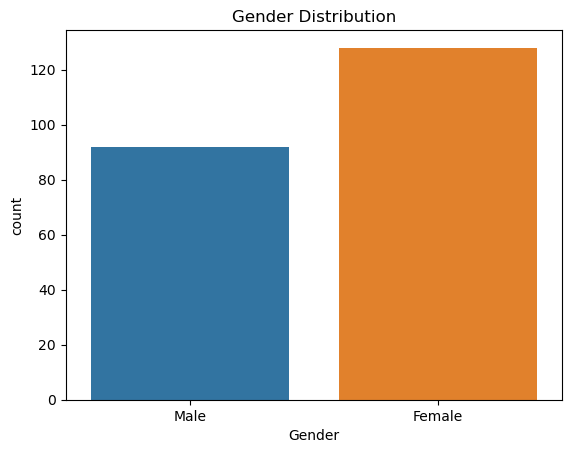

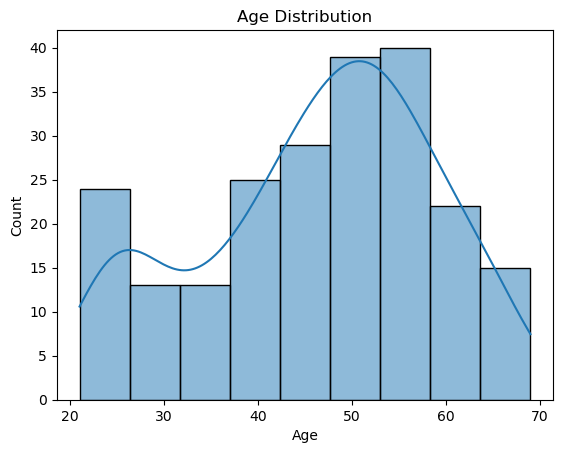

In [25]:
# Visualize gender distribution
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.show()

# Visualize age distribution
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

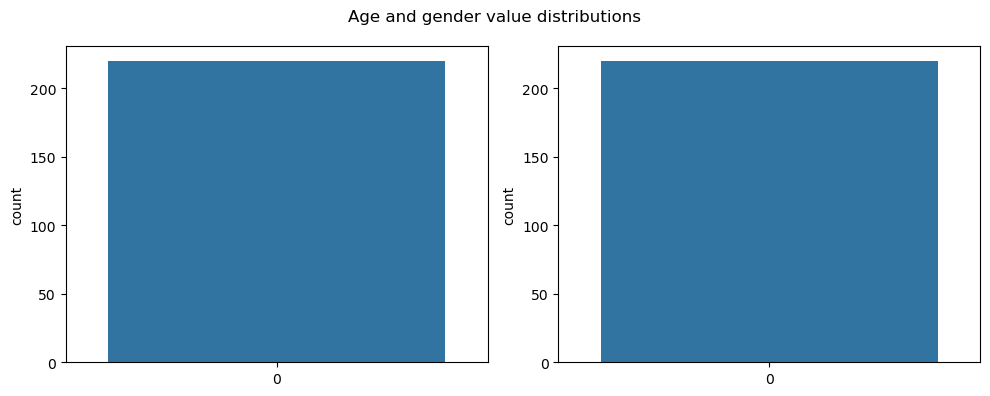

In [19]:
# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.countplot(df[predictors[0]], ax=axes[0])
sns.countplot(df[predictors[1]], ax=axes[1])
fig.suptitle("Age and gender value distributions")
fig.tight_layout()

The group has more females, and the age distribution is slightly skewed. Next, we'll visualize DailyKiloSteps and RestingHR:

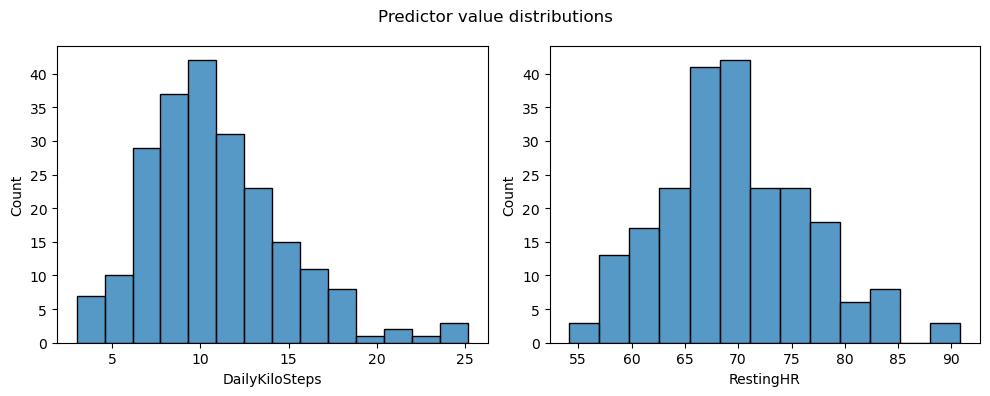

In [14]:
# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.histplot(df[predictors[2]], ax=axes[0])
sns.histplot(df[predictors[3]], ax=axes[1])
fig.suptitle("Predictor value distributions")
fig.tight_layout()

We note that predictor value distributions have high values, being right-skewed; otherwise, they look normally distributed. 

Then, we'll visualize how common different Phenotypes are:

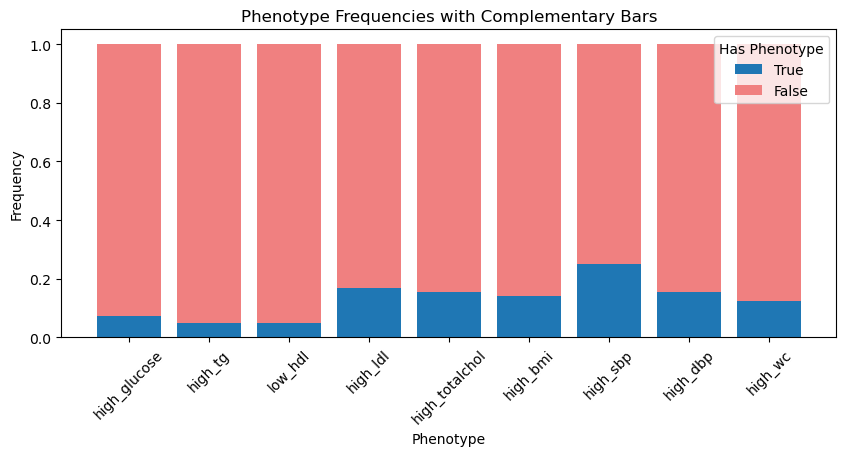

In [20]:
# Calculate the mean frequency for each phenotype
mean_frequencies = df[phenotypes].mean()

# Calculate the complementary frequencies to extend the bars to 1
complementary_frequencies = 1 - mean_frequencies

# Plotting the original frequencies
plt.figure(figsize=(10, 4))
plt.bar(mean_frequencies.index, mean_frequencies, label='True', )

# Stacking the complementary frequencies on top of the original ones
plt.bar(mean_frequencies.index, complementary_frequencies, bottom=mean_frequencies, label='False', color='#f08080')

plt.title("Phenotype Frequencies with Complementary Bars")
plt.xlabel("Phenotype")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.legend(title='Has Phenotype')
plt.show()



We see that the phenotype frequencies are relatively low, so the data is not well-balanced.

Next, we'll check phenotype frequencies within the subjects.

In [21]:
df['tot_phenotypes'] = df[phenotypes].sum(axis=1)

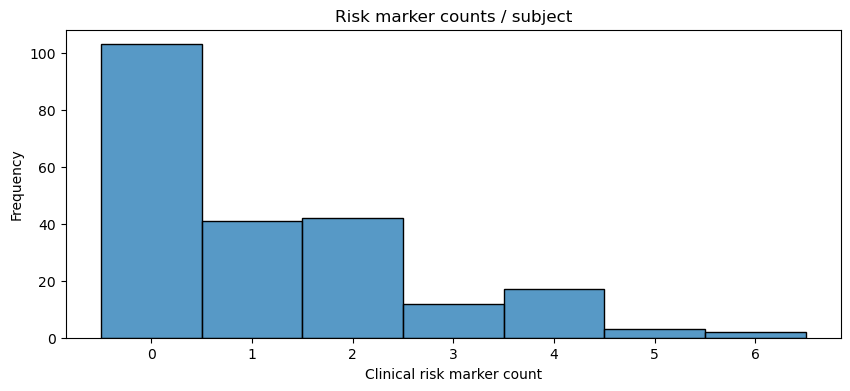

In [22]:
# plot
plt.figure(figsize=(10,4))
ax=sns.histplot(data=df, x="tot_phenotypes",bins=7,discrete=True)
plt.title("Risk marker counts / subject")
plt.xlabel("Clinical risk marker count")
plt.ylabel("Frequency")
plt.show()

Here, we notice that over 100 subjects have no clinical risk markers, and some have multiple markers.

Next, we'll examine correlations with the heatmap. 

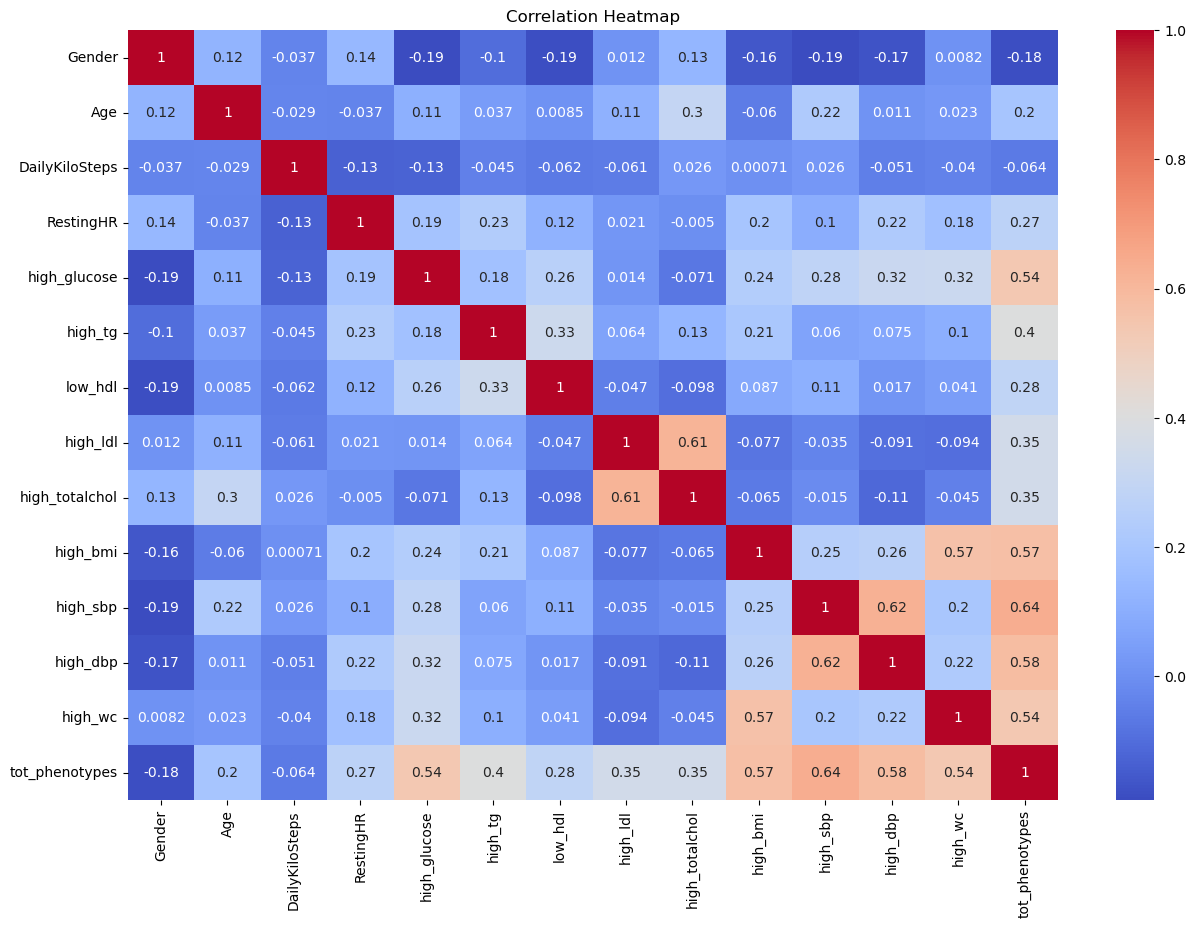

In [23]:
# Generate a correlation heatmap for numerical features and phenotypes
correlation_matrix = df.corr()

# plot
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

This heatmap shows the Pearson correlation coefficients between various predictors (Gender, Age, DailyKiloSteps, RestingHR) and phenotypes (clinical risk markers for cardiovascular diseases). The following lists provide interpretations of these correlations, shedding light on how predictors might be associated with different phenotypes based on the observed data.

**Predictors:**
- **Gender:** Generally negatively correlated with most phenotypes, indicating that a higher **Gender** value (in this data, 'Female') is associated with a decreased risk for these phenotypes.
- **Age:** Positively correlated with **high_totalchol**, **high_sbp**, and **tot_phenotypes**, suggesting older age is associated with higher total cholesterol, higher systolic blood pressure, and more phenotypes.
- **DailyKiloSteps:** Negatively correlated with **RestingHR** and several phenotypes, implying that a higher daily step count is linked to a lower resting heart rate and risk for these phenotypes.
- **RestingHR:** Shows positive correlation with many phenotypes, indicating that a higher resting heart rate is associated with an increased risk of these phenotypes.

**Phenotypes:**
- **high_glucose** is strongly positively correlated with **tot_phenotypes**, suggesting individuals with high glucose typically have more phenotypes.
- **high_bmi** is notably positively correlated with **high_wc** and **tot_phenotypes**, indicating that a higher BMI is linked to a larger waist circumference and more phenotypes.
- **high_ldl** has a moderate positive correlation with **high_totalchol**, which is logical since total cholesterol includes LDL (Low-Density Lipoprotein) and HDL (High-Density Lipoprotein).
- **high_sbp** and **high_dbp** exhibit a strong positive correlation, expectedly, as they are both blood pressure measures.
- **tot_phenotypes** has significant positive correlations with several individual phenotypes, indicating the co-occurrence of multiple phenotypes in individuals.

**Disclaimer:** *The interpretations provided above are based solely on this example dataset and are not medical advice or explanations given by healthcare professionals. Correlations do not imply causation, and further analysis would be necessary to establish causal relationships and control for potential confounding factors.*


---

## 6. Logistic Regression <a class="anchor" id="section6"></a>

In this exercise, we use [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model to conduct **binary classification** to see how well predictors **age**, **gender**, **DailyKiloSteps**, and **RestingHR** can predict the **phenotypes**.

> In this section, we will:
> - run a logistic regression model
> - explore how to scale features
> - validate the model's performance using cross-validation
> - evaluate the model with different metrics

We use **feature scaling**, **cross-validation**, and **model validation** to build more robust classification models.

## 6.1. Logistic Regression, Feature Scaling, Cross-validation and Model Evaluation <a class="anchor" id="section6_1"></a>

This section briefly introduces logistic regression, feature scaling, cross-validation, and model evaluation.

**Logistic Regression**

In this section, we use a logistic regression model instead of linear regression since the target variable (different phenotypes) is binomial here. The assignment uses scikit-learn implementation for [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**Feature Scaling**

Feature scaling is an important step in the data preprocessing pipeline for most machine learning algorithms. We use Standard Scaler to standardize the features by subtracting the mean and scaling them to unit variance. Scaling ensures that each feature contributes equally to the distance-based calculations in the model.

For more information, refer to [scikit-learn's StandardScaler documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

**Cross-validation**

Cross-validation is a technique to assess the model's performance when the true error is unknown. Stratified K-Fold cross-validation ensures that each fold has the same proportion of observations with a given label. It provides a more reliable measure of the model's performance than a single train-test split.

For more details, consult [scikit-learn's StratifiedKFold documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

**Model Evaluation Metrics**

Model evaluation is another critical step in the machine-learning pipeline. It involves assessing the performance of a predictive model to understand its accuracy and effectiveness in capturing underlying patterns in the data. Employing various metrics helps in quantifying different aspects of performance, ensuring that the model generalizes well to unseen data, and identifying areas for improvement. Below, we explore several key metrics used for evaluating binary classifiers.

For a more comprehensive overview, check the [Wikipedia article on the Evaluation of binary classifiers](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers).

#### i) Accuracy

Accuracy represents the proportion of predictions that the model gets right out of all the datasets' examples, offering a broad view of the model's performance overall categories.

Refer to [Accuracy in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

#### ii) Precision

Precision is the fraction of actual positive cases among the total predicted as positive (true positives + false positives). It measures the classifier's accuracy in identifying positive instances, with high precision indicating a lower occurrence of false positives.

Refer to [Precision in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html).

#### iii) Recall

Recall is the proportion of true positives the classifier identifies out of all actual positive cases (true positives + false negatives). It assesses the classifier's ability to capture all relevant instances, with high recall signifying a minimal number of false negatives.

Refer to [Recall in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html).

#### iv) F1-score

The F1-score is the harmonic mean between precision and recall, offering a singular metric that encapsulates the concern for accuracy and completeness in a model's predictions.

Refer to [F1-score in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).


## 6.2. Implementation <a class="anchor" id="section6_2"></a>

In this exercise, we use scikit-learn implementations. We'll start by importing the necessary libraries.

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

We'll start by initializing the classifier, scaler, and cross-validator objects.

&#x1F4DD; **Task:**

- Initialize [logistic regression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) as `clf` 
- Initialize [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) as `scaler`
- Initialize [Stratified K-Fold crossvalidator](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) -object as `skf`, using parameters:
    - 'n_splits' = 5
    - 'random_state' = 42
    - 'shuffle' = True

In [26]:
# Initialize logistic regression classifier
clf = LogisticRegression()

# Initialize standard scaler
scaler = StandardScaler()

# Initialize Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
### HIDDEN TESTS

Your task is to build a simple logistic regression model, which takes one of the **predictors** as input `X` and one of the **phenotypes** as target value `y`. Next, predict each phenotype with the predictors, using feature scaling and cross-validation. For each phenotype, store model evaluation metrics (**accuracy**, **precision**, **recall**, and **F1-score**) on corresponding lists. Complete missing parts on the following for loop.

&#x1F4DD; **Task:**
- Scale the training data `X_train` and test data `X_test`using standard scaler `scaler`trained on `X_train`.
- Fit logistic regression model `clf` on scaled `X_train` and `y_train`
- Use fitted model `clf` to predict labels `y_pred` for the scaled test data `X_test` 
- Compute validation metrics and append those on corresponding lists:
    - `accuracy_list`: [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
    - `precision_list`: [precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html), use additional parameter 'zero_division=0'
    - `recall_list`: [recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
    - `f1_list`: [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), use addtional parameter 'zero_division=0'

In [27]:
# Prepare the common features data (assuming they are common across all phenotypes)
X = df[predictors]

# Initialize lists for the average results
avg_accuracy_list, avg_precision_list, avg_recall_list, avg_f1_list = [], [], [], []

# Loop through each phenotype in your DataFrame
for phenotype in phenotypes:
    # Initialize lists for the results of each fold
    accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
    
    # Prepare the target data
    y = df[phenotype]
    
    # Loop through each fold in stratified k-fold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale the training and test data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit logistic regression model
        clf.fit(X_train_scaled, y_train)

        # Predict labels for the test data
        y_pred = clf.predict(X_test_scaled)

        # Compute validation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Append metrics to corresponding lists
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        
    # Compute the average metrics for this phenotype and append to average lists
    avg_accuracy_list.append(np.mean(accuracy_list))
    avg_precision_list.append(np.mean(precision_list))
    avg_recall_list.append(np.mean(recall_list))
    avg_f1_list.append(np.mean(f1_list))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Phenotype': phenotypes,
    'Average Accuracy': avg_accuracy_list,
    'Average Precision': avg_precision_list,
    'Average Recall': avg_recall_list,
    'Average F1 Score': avg_f1_list
})

In [ ]:
### HIDDEN TESTS

## 6.3. Model Evaluation <a class="anchor" id="section6_3"></a>

Next, we will evaluate the model by inspecting the validation metrics:

In [28]:
results_df

,Phenotype,Average Accuracy,Average Precision,Average Recall,Average F1 Score
0,high_glucose,0.913636,0.0,0.000000,0.000000
1,high_tg,0.950000,0.0,0.000000,0.000000
2,low_hdl,0.950000,0.0,0.000000,0.000000
3,high_ldl,0.831818,0.0,0.000000,0.000000
4,high_totalchol,0.836364,0.2,0.028571,0.050000
5,high_bmi,0.863636,0.2,0.028571,0.050000
6,high_sbp,0.754545,0.5,0.163636,0.218315
7,high_dbp,0.840909,0.3,0.057143,0.094444
8,high_wc,0.877273,0.0,0.000000,0.000000


We also visualize the classification task (**high_wc**) results with the confusion matrix:

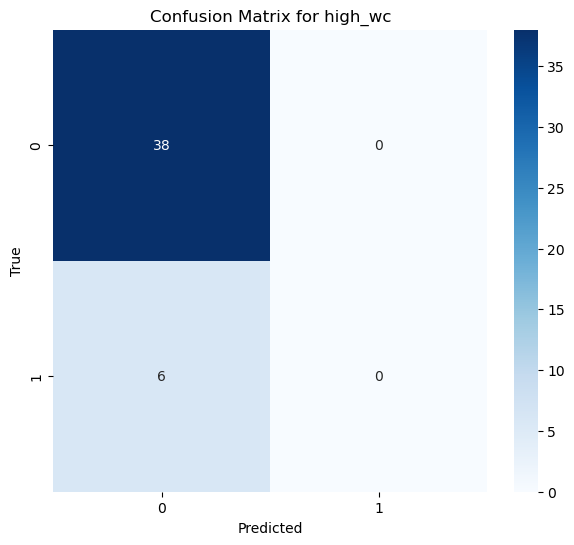

In [29]:
# Compute and print/display the confusion matrix for the selected phenotype
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for high_wc')
plt.show()

The results indicate several key points about the performance of the model:

1. **High Accuracy, Low Precision/Recall/F1-Score**: The high accuracy across all phenotypes suggests that the model is proficient at classifying the majority class (subjects not having the phenotype). However, the low Precision, Recall, and F1-Score values, especially for some phenotypes, indicate that the model struggles to correctly classify the minority class (subjects having the phenotype).

2. **Class Imbalance Impact**: The class imbalance in the dataset is likely contributing to this discrepancy in metric values. The model may be biased towards predicting the majority class, hence achieving high accuracy, but failing to capture the characteristics of the minority class, resulting in low Precision, Recall, and F1-Score.

3. **Potential for Improvement**: The model's difficulty in predicting positive cases suggests room for improvement. Addressing class imbalance, tuning model parameters, or exploring different modeling approaches might enhance the model's ability to predict both classes more effectively.

In conclusion, while the model demonstrates good overall accuracy, its ability to identify positive cases of phenotypes is limited, necessitating further investigation and potential adjustments to the modeling approach. We'll do that in the following sections.

---

## 7. Logistic Regression with SMOTE <a class="anchor" id="section7"></a>

In the previous section, we noticed the classification accuracy was relatively high; meanwhile, precision, recall, and F1-scores were rather poor. The low scores are due to the imbalanced classes. Machine learning models can become biased towards the majority class in an imbalanced dataset, where the classes are not equally represented. This problem can be alleviated in several ways. For example, one way is to assign class weights in the model. In sklearn, this can be done by adding the logistic regression model parameter `class_weight='balanced'`, which automatically balances the classes. For details, check [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). In this exercise, we introduce and utilize a data [oversampling technique](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) instead. 

## 7.1. Data oversampling and SMOTE <a class="anchor" id="section7_1"></a>

While some classifiers in scikit-learn offer a `class_weight` parameter to adjust data imbalance, it's not universally available — for example, K-Nearest Neighbors (KNN) lack this feature. Therefore, data oversampling techniques like SMOTE can be a more versatile solution. Oversampling provides a balanced dataset, leading to more reliable and interpretable classification metrics.

SMOTE (Synthetic Minority Over-sampling Technique) balances the dataset by generating synthetic samples in the feature space. Unlike setting `class_weight`, SMOTE actually alters the dataset, providing a more balanced class distribution. It works by selecting instances of the minority class and creating similar synthetic instances to balance out the class distribution.

For more details, refer to the original paper on [SMOTE by Chawla et al. (2002)](https://doi.org/10.1613/jair.953)[3].

## 7.2. Implementation <a class="anchor" id="section7_2"></a>

In this exercise, we use the SMOTE function from imbalanced-learn library. See [imbalanced-learn documentation](https://imbalanced-learn.org/stable/user_guide.html) documentation for details.

The code in this section is split the code into functions. Your task is to fill in the missing parts of `perform_smote`function: 

📝 **Task:**
- complete perform_smote() function
- start by checking the function docstrings and [SMOTE documentation](https://imbalanced-learn.org/stable/over_sampling.html)

&#x1F4A1; Note that the function `run_experiment()` uses Stratified K-Folds cross-validator `skf`, defined in previous section.

First, we import the imblearn library:

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
def prepare_data(df, features, target):
    """
    Prepare the feature matrix X and target vector y from the given DataFrame.

    Parameters:
    - df (DataFrame): The source DataFrame.
    - features (list): List of feature column names.
    - target (str): The target column name.

    Returns:
    - X (DataFrame): Feature matrix.
    - y (Series): Target vector.
    """
    X = df[features]
    y = df[target]
    return X, y

def train_and_evaluate(clf, X_train, y_train, X_test, y_test, scaler=None):
    """
    Train and evaluate a machine learning classifier.

    Parameters:
    - clf (Classifier): The machine learning classifier.
    - X_train (DataFrame): Training feature matrix.
    - y_train (Series): Training target vector.
    - X_test (DataFrame): Test feature matrix.
    - y_test (Series): Test target vector.
    - scaler (Scaler, optional): The scaler object for feature scaling.

    Returns:
    - accuracy (float): Accuracy score.
    - precision (float): Precision score.
    - recall (float): Recall score.
    - f1 (float): F1 score.
    """
    if scaler:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    return accuracy, precision, recall, f1

def perform_smote(X, y):
    """
    Perform SMOTE (Synthetic Minority Over-sampling Technique) on the data.

    Parameters:
    - X (DataFrame): Feature matrix.
    - y (Series): Target vector.

    Returns:
    - X_resampled (DataFrame): Resampled feature matrix.
    - y_resampled (Series): Resampled target vector.
    """
    
    # Initialize SMOTE
    smote = SMOTE(random_state=42)
    
    # Perform SMOTE on the data
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled

def run_experiment(df, features, target, clf, use_smote=False, use_scaler=False):
    """
    Run a machine learning experiment.

    Parameters:
    - df (DataFrame): The source DataFrame.
    - features (list): List of feature column names.
    - target (str): The target column name.
    - clf (Classifier): The machine learning classifier.
    - use_smote (bool, optional): Whether to use SMOTE for data balancing.
    - use_scaler (bool, optional): Whether to scale the features.

    Returns:
    - avg_metrics (dict): Dictionary containing the average metrics.
    """
    X, y = prepare_data(df, features, target)
    avg_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if use_smote:
            X_train, y_train = perform_smote(X_train, y_train)
        
        accuracy, precision, recall, f1 = train_and_evaluate(clf, X_train, y_train, X_test, y_test, scaler if use_scaler else None)
        
        avg_metrics['accuracy'].append(accuracy)
        avg_metrics['precision'].append(precision)
        avg_metrics['recall'].append(recall)
        avg_metrics['f1'].append(f1)
        
    for metric, values in avg_metrics.items():
        avg_metrics[metric] = np.mean(values)
        
    return avg_metrics


In [ ]:
### HIDDEN TESTS

Next, we will run the logistic regression with SMOTE.

In [32]:
# Create a list for classifiers
# this list can be extended to include other classifiers for experimentation
clfs = [clf]

# Initialize an empty list to store the results of each experiment
results = []

# Loop through each phenotype in 'phenotypes' list to perform experiments
for phenotype in phenotypes:

    # Loop through the SMOTE option (True for using SMOTE, False for not using it)
    for use_smote in [True, False]:

        # Loop through each classifier specified in the 'clfs' list
        for clf in clfs:

            # Run the experiment with the current settings and get metrics
            # 'run_experiment' is a function that performs the machine learning experiment
            # and returns evaluation metrics
            metrics = run_experiment(df, predictors, phenotype, clf, use_smote=use_smote, use_scaler=True)

            # Append the results of the current experiment to the 'results' list
            # This includes the phenotype, classifier used, whether SMOTE was used, and the metrics
            results.append({'Phenotype': phenotype, 'Classifier': str(clf), 'SMOTE': use_smote, **metrics})

# Convert the 'results' list into a Pandas DataFrame for easier analysis and visualization
results_df = pd.DataFrame(results)


## 7.3. Model Evaluation <a class="anchor" id="section7_3"></a>

Lets have a look at the results:

In [33]:
results_df

,Phenotype,Classifier,SMOTE,accuracy,precision,recall,f1
0,high_glucose,LogisticRegression(),True,0.763636,0.179739,0.633333,0.276667
1,high_glucose,LogisticRegression(),False,0.913636,0.000000,0.000000,0.000000
2,high_tg,LogisticRegression(),True,0.809091,0.123956,0.566667,0.200000
3,high_tg,LogisticRegression(),False,0.950000,0.000000,0.000000,0.000000
4,low_hdl,LogisticRegression(),True,0.700000,0.096387,0.633333,0.167238
5,low_hdl,LogisticRegression(),False,0.950000,0.000000,0.000000,0.000000
6,high_ldl,LogisticRegression(),True,0.586364,0.179221,0.403571,0.247594
7,high_ldl,LogisticRegression(),False,0.831818,0.000000,0.000000,0.000000
8,high_totalchol,LogisticRegression(),True,0.677273,0.299426,0.733333,0.421650
9,high_totalchol,LogisticRegression(),False,0.836364,0.200000,0.028571,0.050000


📝 **Task:**
- Inspect the model evaluation results, consider the application domain and SMOTE in general, and answer the following multiple choices questions by adding the right choices ('A', 'B', 'C', or 'D') in the following code cell after question names.
- Please do not alter the answer names.


### Question 1: 
**Which of the following is true about the impact of SMOTE on model accuracy?**
- A) SMOTE consistently increases model accuracy across all phenotypes.
- B) SMOTE has no impact on model accuracy.
- C) SMOTE consistently decreases model accuracy across all phenotypes.
- D) The impact of SMOTE on model accuracy varies significantly across different phenotypes.

### Question 2:
**What is the significance of an increase in precision with the application of SMOTE?**
- A) The model is more likely to miss positive instances.
- B) The model is less exact and produces more false positives.
- C) The model is more exact and produces fewer false positives.
- D) The model will have decreased recall.

### Question 3:
**Why is an increase in recall particularly important in medical applications?**
- A) Because high recall means more false positives.
- B) Because failing to identify positive cases can have serious consequences.
- C) Because it leads to higher accuracy.
- D) Because it signifies a higher number of true negatives.

### Question 4:
**What does an increase in the F1-score signify with the application of SMOTE?**
- A) The model is leaning towards higher precision and lower recall.
- B) The model is leaning towards lower precision and higher recall.
- C) The model has a more holistic balance between precision and recall.
- D) The model’s accuracy has increased significantly.

### Question 5:
**Which of the following considerations is important when deciding to use SMOTE?**
- A) The degree of imbalance in the dataset and the specific context of the application.
- B) The overall increase in model accuracy.
- C) The decrease in the number of true negatives.
- D) The consistent impact of SMOTE across all phenotypes.


In [35]:
# Your answer here. For example, if you choose option A for question 1, write: answer_1 = 'A'
answer_1 = 'C'
answer_2 = 'C'
answer_3 = 'B'
answer_4 = 'C'
answer_5 = 'A'

In [ ]:
### HIDDEN TESTS

In [ ]:
### HIDDEN TESTS

In [ ]:
### HIDDEN TESTS

In [ ]:
### HIDDEN TESTS

In [ ]:
### HIDDEN TESTS

## 8. Logistic Regression with Feature Engineering <a class="anchor" id="section8"></a>

In this section, we will explore the concept of feature engineering, specifically focusing on generating polynomial and interaction terms. We'll implement the feature engineering steps and evaluate how these new features affect our model's performance.


### 8.1 Feature Engineering  <a class="anchor" id="section8_1"></a>

Feature engineering involves transforming or creating new features to improve model performance. In this exercise, we focus on generating polynomial and interaction terms. Polynomial features are created by raising an existing feature to a power. Interaction terms are made by multiplying two or more features. These new features can capture complex relations between the variables that linear models may not otherwise capture.

For more details on polynomial features in scikit-learn, refer to [PolynomialFeatures documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).


### 8.2. Implementation <a class="anchor" id="section8_2"></a>

We'll start by importing the `PolynomialFeatures` function.

In [36]:
from sklearn.preprocessing import PolynomialFeatures

In this exercise, the code is split into functions. Your task is to fill in the missing parts.

📝 **Task**: 
- Complete the `prepare_data`function by completing the missing feature transformation
    - Initialize a `PolynomialFeatures` object as `poly` with the following parameters:
        - 'degree' = 2
        - 'interaction_only' = False
        - 'include_bias' = False 
    - Fit and transform features dataframe `X` using `poly` 


In [40]:
def prepare_data(df, features, target, use_poly_features=False):
    """
    Prepare the feature matrix (X) and target vector (y) from a DataFrame.
    
    Parameters:
    df (DataFrame): Source DataFrame.
    features (list): List of feature column names.
    target (str): Target column name.
    
    Optional:
    use_poly_features (bool): Generate polynomial and interaction features (default: False).
    
    Returns:
    X (DataFrame): Feature matrix.
    y (Series): Target vector.
    """
    
    X = df[features]
    y = df[target]
    
    if use_poly_features:
        # Create polynomial and interaction features using scikit-learn's PolynomialFeatures.
        # For more details, refer to scikit-learn's PolynomialFeatures documentation: 
        # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
        
        poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
        X = poly.fit_transform(X)
        
        # Convert the resulting NumPy array back to a DataFrame
        X = pd.DataFrame(X, columns=poly.get_feature_names_out(input_features=features))
        
    return X, y


def run_experiment(df, features, target, clf, use_smote=False, use_scaler=False, use_poly_features=False):
    """
    Run a machine learning experiment.

    Parameters:
    - df (DataFrame): The source DataFrame.
    - features (list): List of feature column names.
    - target (str): The target column name.
    - clf (Classifier): The machine learning classifier.
    - use_smote (bool, optional): Whether to use SMOTE for data balancing.
    - use_scaler (bool, optional): Whether to scale the features.
    - use_poly_features (bool, optional): Whether to generate polynomial and interaction features.
    
    Returns:
    - avg_metrics (dict): Dictionary containing the average metrics.
    """
    X, y = prepare_data(df, features, target, use_poly_features=use_poly_features)
    avg_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if use_smote:
            X_train, y_train = perform_smote(X_train, y_train)
        
        accuracy, precision, recall, f1 = train_and_evaluate(clf, X_train, y_train, X_test, y_test, scaler if use_scaler else None)
        
        avg_metrics['accuracy'].append(accuracy)
        avg_metrics['precision'].append(precision)
        avg_metrics['recall'].append(recall)
        avg_metrics['f1'].append(f1)
        
    for metric, values in avg_metrics.items():
        avg_metrics[metric] = np.mean(values)
        
    return avg_metrics

In [ ]:
### HIDDEN TESTS


In [41]:
# Initialize an empty list to store the results of each experiment
results = []

# Loop through each phenotype to perform experiments
# Replace 'phenotypes' with your actual list of phenotypes
for phenotype in phenotypes:

    # Loop through the SMOTE option (True for using SMOTE, False for not using it)
    for use_smote in [True, False]:

        # Loop through each classifier specified in the 'clfs' list
        for clf in clfs:  # Add more classifiers to the 'clfs' list as needed

            # Loop through the polynomial features option
            # True for using polynomial features, False for not using them
            for use_poly_features in [True, False]:

                # Run the experiment with the current settings and get metrics
                # 'run_experiment' is a function that performs the machine learning experiment
                # and returns evaluation metrics
                metrics = run_experiment(df, predictors, phenotype, clf, use_smote=use_smote, use_scaler=True, use_poly_features=use_poly_features)

                # Append the results of the current experiment to the 'results' list
                # This includes the phenotype, classifier used, whether SMOTE was used,
                # whether polynomial features were used, and the evaluation metrics
                results.append({'Phenotype': phenotype, 'Classifier': str(clf), 'SMOTE': use_smote, 'PolyFeatures': use_poly_features, **metrics})

# Convert the 'results' list into a Pandas DataFrame for easier analysis and visualization
results_df = pd.DataFrame(results)


### 8.3. Model Evaluation  <a class="anchor" id="section8_3"></a>

In [42]:
results_df

,Phenotype,Classifier,SMOTE,PolyFeatures,accuracy,precision,recall,f1
0,high_glucose,LogisticRegression(),True,True,0.768182,0.182943,0.633333,0.277922
1,high_glucose,LogisticRegression(),True,False,0.763636,0.179739,0.633333,0.276667
2,high_glucose,LogisticRegression(),False,True,0.913636,0.000000,0.000000,0.000000
3,high_glucose,LogisticRegression(),False,False,0.913636,0.000000,0.000000,0.000000
4,high_tg,LogisticRegression(),True,True,0.822727,0.180952,0.533333,0.248377
5,high_tg,LogisticRegression(),True,False,0.809091,0.123956,0.566667,0.200000
6,high_tg,LogisticRegression(),False,True,0.950000,0.000000,0.000000,0.000000
7,high_tg,LogisticRegression(),False,False,0.950000,0.000000,0.000000,0.000000
8,low_hdl,LogisticRegression(),True,True,0.690909,0.084725,0.566667,0.147391
9,low_hdl,LogisticRegression(),True,False,0.700000,0.096387,0.633333,0.167238


📝 **Task:**
-  Inspect the model evaluation result and answer the following multiple-choice questions by adding the right choices ('A', 'B', 'C', or 'D') in the following code cell after question names.
- Please do not alter the answer names.

### Question 1:

**What is observed regarding the model's accuracy with adding polynomial and interaction terms across different phenotypes?**
- A) Accuracy remains unchanged for all phenotypes.
- B) The effect on accuracy varies, with some phenotypes showing improvement while others remain unchanged or even decline.
- C) Accuracy consistently increases for all phenotypes.
- D) Accuracy consistently decreases for all phenotypes


### Question 2:

**How does adding polynomial and interaction terms impact precision, recall, and F1-score?**

- A) These metrics consistently decrease for all phenotypes.
- B) These metrics show no improvement for any of the phenotypes.
- C) The impact on these metrics is inconsistent, with some phenotypes showing improvement, while the metrics may remain the same or decrease for others.
- D) These metrics consistently improve for all phenotypes.

### Question 3:

**What does the varied effect of polynomial and interaction terms on model performance suggest?**

- A) Feature engineering has no real impact on model performance.
- B) Polynomial and interaction terms only affect the model's accuracy.
- C) Feature engineering is always beneficial for improving model performance.
- D) The effectiveness of feature engineering depends on the type of data and the specific relationships within it, requiring careful evaluation.

In [2]:
# Your answer here. For example, if you choose option A for question 1, write: answer_1 = 'A'
answer_1 = 'A'
answer_2 = 'C'
answer_3 = 'D'

In [ ]:
### HIDDEN TESTS

In [ ]:
### HIDDEN TESTS

In [ ]:
### HIDDEN TESTS

## 9. Trying various classifiers  <a class="anchor" id="section9"></a>

This section aims to evaluate the performance of various classifiers, including **Logistic Regression**, **Support Vector Classifier (SVC)**, **Random Forest**, and **K-Nearest Neighbors (KNN)**. By comparing these classifiers, we hope to identify which model performs best for different phenotypes, considering both imbalanced and balanced data (using SMOTE) and the impact of additional features.

### 9.1. SVC, KNN, and Random Forest Classifier <a class="anchor" id="section9_1"></a>

In addition to Logistic Regression, we explore three other classifiers:

- Support Vector Classifier (SVC): A classifier that creates hyperplanes in high-dimensional space to distinguish between different classes, particularly effective for complex decision boundaries. 

- Random Forest Classifier: An ensemble learning method that constructs numerous decision tree classifiers on different subsets of the dataset and employs the mean of their predictions to enhance overall predictive accuracy.

- K-Nearest Neighbors (KNN):  A simple algorithm that assigns a category to a data point depending on the classifications of its closest neighbors. 

Different classifiers have different strengths and weaknesses. Logistic regression is simple and interpretable but may not capture complex relationships between features. In contrast, other classifiers like Random Forest and SVC can capture more complex patterns but are less interpretable.

### 9.2. Implementation <a class="anchor" id="section9_2"></a>

In this section, we are implementing experiments using various classifiers. Here is a brief description and references for each classifier:

1. **Logistic Regression**: A statistical model used for binary classification problems. 
[Scikit-learn Documentation for Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

2. **Support Vector Classifier (SVC)**: A type of SVM often used for binary or multi-class classification tasks.
[Scikit-learn Documentation for SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

3. **Random Forest Classifier**: An ensemble learning method that fits multiple decision tree classifiers and uses averaging to improve predictive accuracy.
[Scikit-learn Documentation for Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

4. **K-Nearest Neighbors (KNN)**: A simple algorithm that retains all available data points and classifies new instances based on a similarity measure.
[Scikit-learn Documentation for KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Feel free to refer to the documentation for a deeper understanding of the parameters and usage of these classifiers.


In this exercise, the code is again divided into separate functions. Your task is to initialize different classifiers.

📝 **Task:**
- initialize a list named `clfs` containing the following classifiers objects:
    - LogisticRegression(max_iter=1000), using parameter `max_iter=1000`
    - SVC()
    - RandomForestClassifier(), using parameter `random_state=42`
    - KNeighborsClassifier()
        

In [44]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Define classifiers in the clsfs list

clfs = [
    LogisticRegression(max_iter=1000),
    SVC(),
    RandomForestClassifier(random_state=42),
    KNeighborsClassifier()
]

# Initialize an empty list to store the results of each experiment
results = []

# Loop through each phenotype to perform experiments
# Replace 'phenotypes' with your actual list of phenotypes
for phenotype in phenotypes:

    # Loop through the SMOTE option (True for using SMOTE, False for not using it)
    for use_smote in [True, False]:

        # Loop through each classifier specified in the 'clfs' list
        for clf in clfs:  # Add more classifiers to the 'clfs' list as needed

            # Loop through the polynomial features option
            # True for using polynomial features, False for not using them
            for use_poly_features in [True, False]:

                # Run the experiment with the current settings and get metrics
                # 'run_experiment' is a function that performs the machine learning experiment
                # and returns evaluation metrics
                metrics = run_experiment(df, predictors, phenotype, clf, use_smote=use_smote, use_scaler=True, use_poly_features=use_poly_features)

                # Append the results of the current experiment to the 'results' list
                # This includes the phenotype, classifier used, whether SMOTE was used,
                # whether polynomial features were used, and the evaluation metrics
                results.append({'Phenotype': phenotype, 'Classifier': str(clf), 'SMOTE': use_smote, 'PolyFeatures': use_poly_features, **metrics})

# Convert the 'results' list into a Pandas DataFrame for easier analysis and visualization
results_df = pd.DataFrame(results)


### 9.3. Model Evaluations <a class="anchor" id="section9_3"></a>

In [45]:
# Mapping from original classifier names to shortened names
name_mapping = {
    'LogisticRegression(max_iter=1000)': 'LogReg',
    'SVC()': 'SVM',
    'RandomForestClassifier(random_state=42)': 'RandForest',
    'KNeighborsClassifier()': 'KNN'
}

# Update the 'Classifier' column in DataFrame based on this mapping
results_df['Classifier'] = results_df['Classifier'].map(name_mapping)

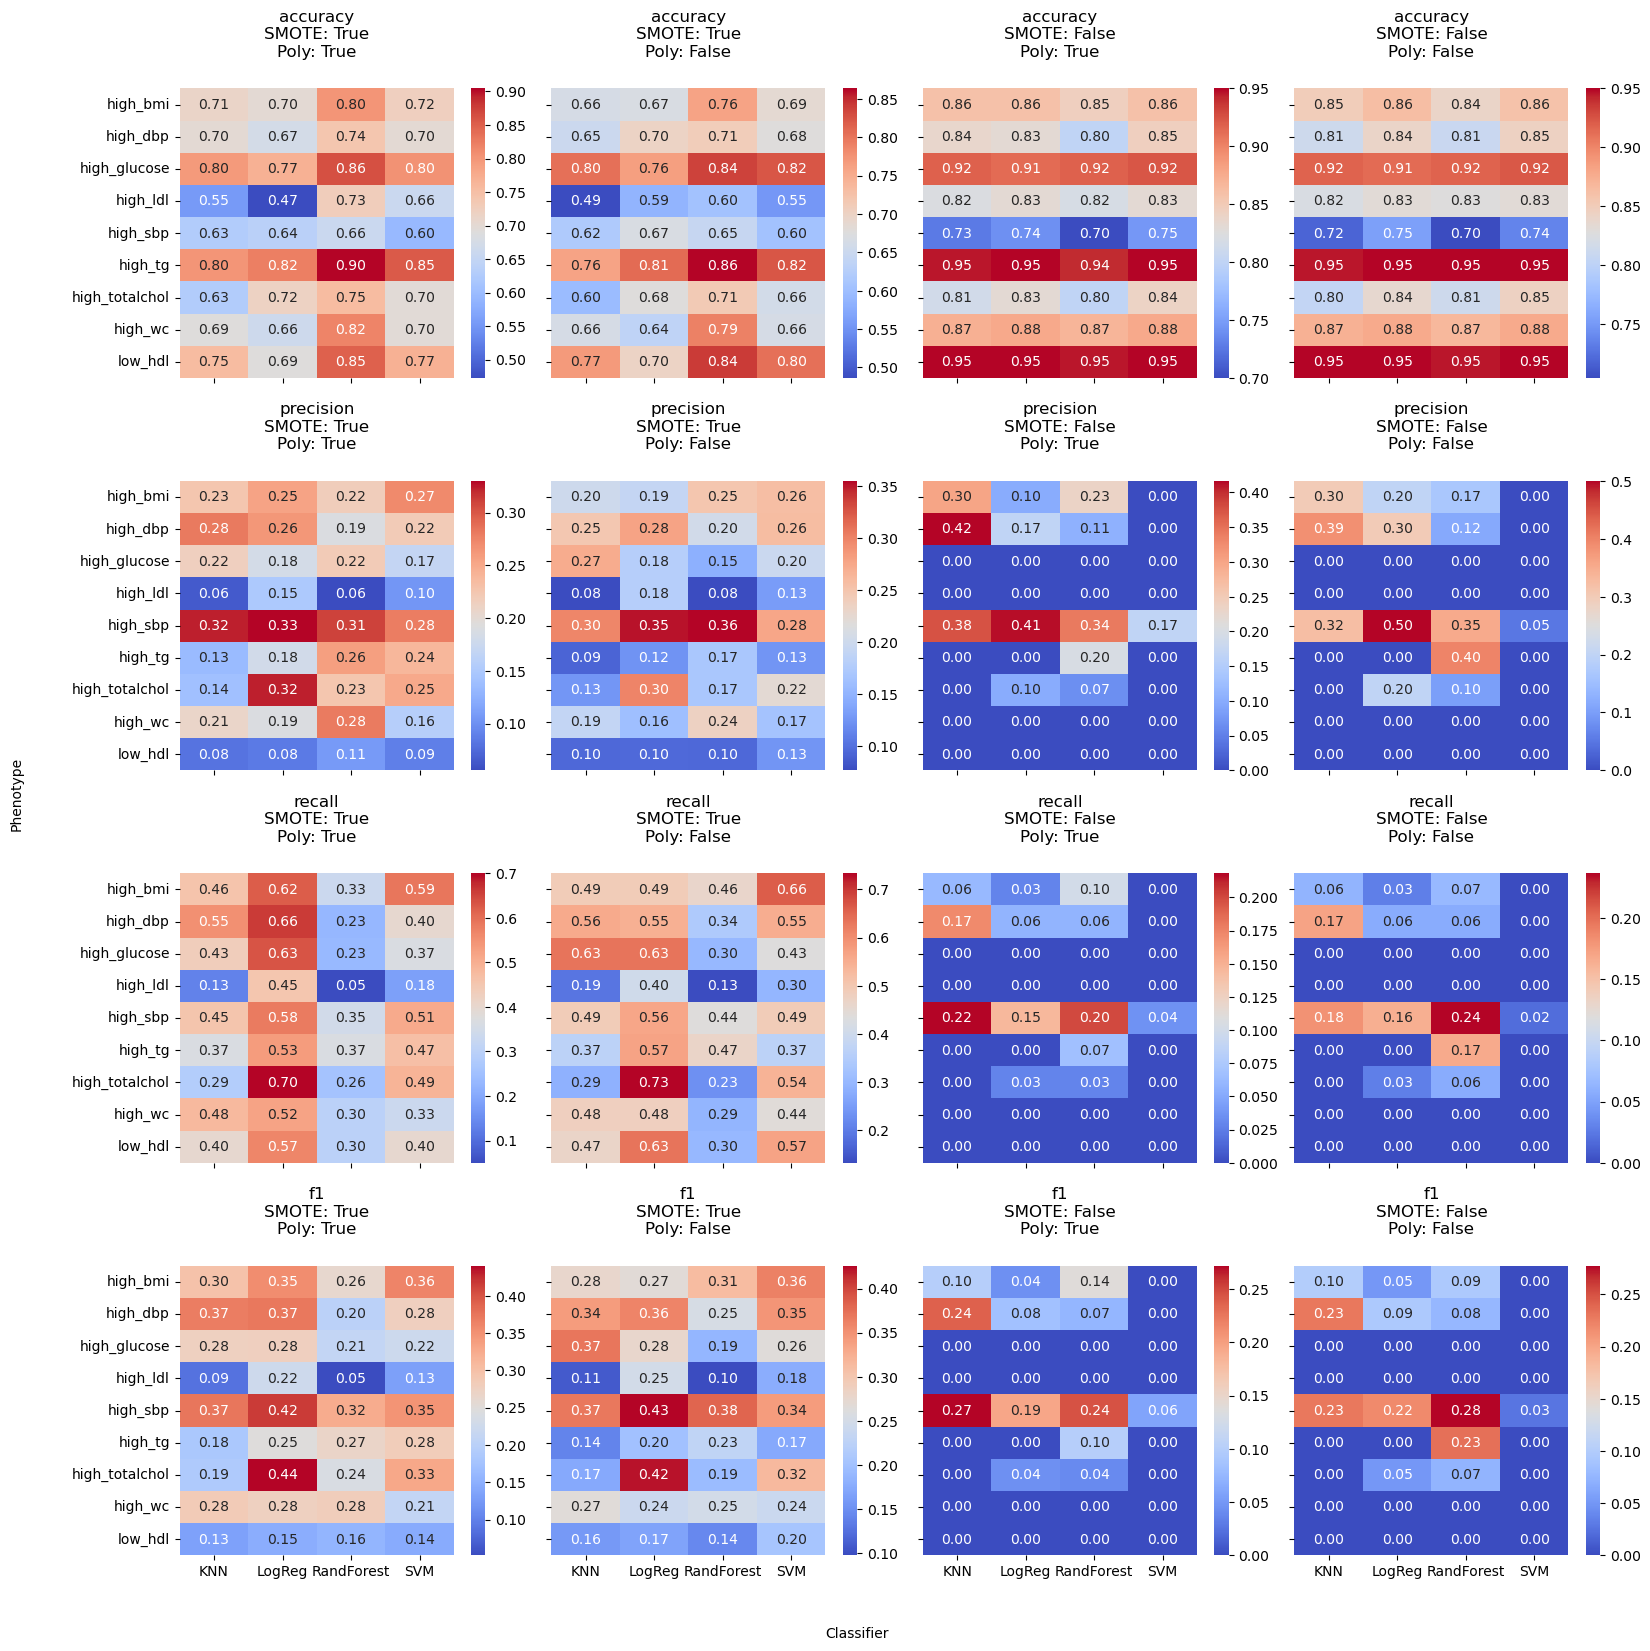

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 4x4 subplots (4 metrics x 4 combinations), sharing x and y labels
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)

# Define the metrics to be plotted
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Define the different combinations of SMOTE and PolyFeatures
combinations = [(True, True), (True, False), (False, True), (False, False)]

# Loop through metrics and combinations to create the heatmaps
for i, metric in enumerate(metrics):
    for j, (use_smote, use_poly) in enumerate(combinations):
        ax = axes[i, j]
        
        # Filter the DataFrame based on the current combination of SMOTE and PolyFeatures
        filtered_df = results_df[(results_df['SMOTE'] == use_smote) & (results_df['PolyFeatures'] == use_poly)]
        
        # Pivot the DataFrame to show classifiers and their metrics for each phenotype
        pivoted_results = pd.pivot_table(filtered_df, 
                                         values=[metric], 
                                         index=['Phenotype'], 
                                         columns=['Classifier'])
        
        # Reset the column names to just the classifier names
        pivoted_results.columns = pivoted_results.columns.droplevel(0)
        
        sns.heatmap(pivoted_results, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
        
        # Add text annotations for the current metric, SMOTE, and PolyFeatures
        annotation = f"{metric}\nSMOTE: {use_smote}\nPoly: {use_poly}"
        ax.text(0.5, 1.1, annotation, fontsize=12, ha='center', va='bottom', transform=ax.transAxes)
        
        # Remove x-labels and y-labels for each subplot to make the plot less cluttered
        ax.set_xlabel('')
        ax.set_ylabel('')

# Add a common x and y label
fig.text(0.5, 0.08, 'Classifier', ha='center', va='center')
fig.text(0.08, 0.5, 'Phenotype', ha='center', va='center', rotation='vertical')

# Adjust layout to prevent overlap and add vertical spacing
plt.subplots_adjust(hspace=0.4)
plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
plt.show()


📝 **Task:**
- Inspect the model evaluation results and answer the following multiple-choice questions by adding the right choices ('A', 'B', 'C', or 'D') in the following code cell after question names.
- Please do not alter the answer names


### Question 1)
**Which classifier generally exhibits a decrease in accuracy with the application of SMOTE, but shows mixed results with the inclusion of polynomial features?**
- A) Logistic Regression
- B) Support Vector Classifier
- C) Random Forest
- D) K-Nearest Neighbors

### Question 2)
**For which classifier does the application of SMOTE generally lead to higher precision, and including polynomial features further enhances this effect?**
- A) Logistic Regression
- B) Support Vector Classifier
- C) Random Forest
- D) K-Nearest Neighbors

### Question 3)
**In which classifier is there a significant improvement in recall with the application of SMOTE, and the combination of SMOTE and polynomial features yields even higher recall?**
- A) Logistic Regression
- B) Support Vector Classifier
- C) Random Forest
- D) K-Nearest Neighbors

### Question 4)
**Which classifiers tend to exhibit higher F1-scores with the use of SMOTE, and this effect is further pronounced with the addition of polynomial features?**
- A) Logistic Regression and Support Vector Classifier
- B) Support Vector Classifier and K-Nearest Neighbors
- C) Logistic Regression and Random Forest
- D) Random Forest and K-Nearest Neighbors

### Question 5)
**Considering all classifiers and metrics, what can be concluded about the general effect of applying SMOTE and polynomial features?**
- A) SMOTE and polynomial features both consistently increase all evaluation metrics.
- B) SMOTE generally improves precision, recall, and F1-score, while the effect of polynomial features varies.
- C) Polynomial features consistently improve all metrics, while SMOTE has a varied impact.
- D) Both SMOTE and polynomial features have inconsistent effects across different metrics and classifiers.

In [ ]:
# Your answer here. For example, if you choose option A for question 1, write: answer_1 = 'A'
answer_1 = 'A'
answer_2 = 'C'
answer_3 = 'A'
answer_4 = 'A'
answer_5 = 'D'

In [ ]:
### HIDDEN TESTS

In [ ]:
### HIDDEN TESTS

In [ ]:
### HIDDEN TESTS

In [ ]:
### HIDDEN TESTS

In [ ]:
### HIDDEN TESTS

## 10. Conclusion <a class="anchor" id="section10"></a>

Digital phenotyping, a novel approach utilizing technology to analyze human behaviors and biological processes, served as the foundation of this exercise. Through assessing the interaction between various predictors and phenotypes, insights into cardiovascular risks were explored.

This exercise initiated a detailed exploration and preprocessing of a cardiovascular dataset, addressing missing values, encoding variables, and mitigating class imbalances. EDA revealed significant correlations between predictors like Age and RestingHR with multiple phenotypes, emphasizing their relevance in cardiovascular risk.

Subsequent feature engineering employed SMOTE for class imbalances and Polynomial Features to enhance model complexity. The varied impact on different phenotypes underscored the need to carefully evaluate such techniques. Logistic Regression was the chosen model, with its performance assessed using metrics like accuracy, precision, recall, and F1-score through Stratified K-Fold cross-validation.

The application of SMOTE and Polynomial Features showcased a trade-off, often enhancing recall and F1-score at the expense of accuracy. This highlighted the importance of a balanced approach, especially in medical applications where high recall is crucial.

Multiple-choice questions interspersed throughout the exercise facilitated reflection on key concepts, such as the impact of feature engineering and the importance of nuanced model evaluation in medical diagnostics.

In conclusion, the exercise illuminated the complexities of imbalanced data, the potential of feature engineering, and the importance of context-specific model evaluation. It paved the way for further exploration into diverse modeling techniques and a deeper understanding of digital phenotyping in predicting health outcomes.

---

## 11. References <a class="anchor" id="section11"></a>

[1] Benoit J, Onyeaka H, Keshavan M, Torous J. (2020). Systematic Review of Digital Phenotyping and Machine Learning in Psychosis Spectrum Illnesses. Harv Rev Psychiatry. (5):296-304. https://pubmed.ncbi.nlm.nih.gov/32796192/

[2] Lim, W. K., Davila, S., Teo, J. X., Yang, C., Pua, C. J., Blöcker, C., ... & Tan, P. (2018). Beyond fitness tracking: the use of consumer-grade wearable data from normal volunteers in cardiovascular and lipidomics research. PLoS biology, 16(2), e2004285. https://doi.org/10.1371/journal.pbio.2004285

[3] Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. Journal of Artificial Intelligence Research, 16, 321-357. https://doi.org/10.1613/jair.953 



